In [ ]:
!pip install celluloid

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.datasets import load_iris
np.random.seed(1)

In [ ]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = np.array(data[:,0:1])
y_train = np.array(data[:,1:2])

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

xt_min = x_train.min()
xt_max = x_train.max()
x_train_n = (x_train - xt_min)/(xt_max - xt_min)

yt_min = y_train.min()
yt_max = y_train.max()
y_train_n = (y_train - yt_min)/(yt_max - yt_min)

x_train_bias = np.concatenate([np.ones((n_samples,1)), x_train_n])
x_train_bias = x_train_bias.reshape((50,2),order='F')
print('x_train_bias shape: ', x_train_bias.shape)

x_train.shape: (50, 1) float64
y_train.shape: (50, 1) float64
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]
x_train_bias shape:  (50, 2)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
np.random.seed(1)


class SigmoidLayer():

  def forward(self, x):
    self.sigfor = 1/(1+np.exp(-x))
    return np.mean(self.sigfor, axis=1)

  def backward(self, upstream_grad):
    #https://math.stackexchange.com/questions/2323370/derivative-of-sigmoid-assuming-input-is-a-matrix
    return upstream_grad * self.sigfor * (1- self.sigfor)

In [ ]:
class SumLayer():

  def forward(self, x, y):
    z = x + y
    return z
  
  def backward(self, upstream_grad):
    return upstream_grad,upstream_grad

In [ ]:
class MulLayer():

  def forward(self, x, y):
    y = y.reshape((model.dim,-1))
    model.mulStack.append([x,y])
    x = x.reshape(-1,1)
    z = x.dot(y.T)
    return z
  
  def backward(self, upstream_grad):
    x,y = model.mulStack.pop()
    x_d = upstream_grad.T.dot(x)
    y_d = upstream_grad.dot(y)
    return y_d, x_d 

In [ ]:
def compute_grad_loss(y_target, y_pred):
  # Escreva o código aqui:
  # loss = (y_pred - y_target) ** 2
  # derivada da loss em relação y_pred
  return 2*(y_pred - y_target)

In [ ]:
class Net():

  def __init__(self, dim):
    # Escreva o código aqui:
    self.dim = dim
    self.w = np.random.rand(dim,1)
    self.b = np.random.rand(x_train_n.shape[0],dim)
    self.Mul = MulLayer()
    self.Sum = SumLayer()
    self.Sig = SigmoidLayer()
    self.mulStack = []

  def forward(self, x):
    # Escreva o código aqui:
    dot = self.Mul.forward(x,self.w)
    sum = self.Sum.forward(dot, self.b)
    sig = self.Sig.forward(sum)
    sig = sig.reshape(-1,1)
    return sig

  def backward(self, upstream_grad):
    # Escreva o código aqui:
    dsig = self.Sig.backward(upstream_grad)
    dsum, db = self.Sum.backward(dsig)
    dx, dw = self.Mul.backward(dsum)
    return dw,db

In [ ]:
def MSELoss(pred, true,axis=1):
  return ((pred - true)**2).mean(axis=axis)

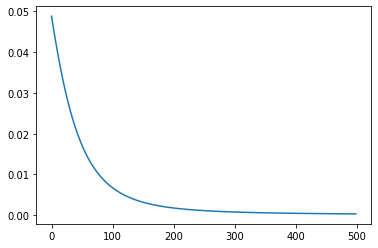

In [ ]:
model = Net(dim=2)
learning_rate = 0.1
# x = -5
# y_target = 0.76
num_iterations = 500

losses = []
w_history = []
out_history = []

for i in range(num_iterations):
  inputs = x_train_n
  target = y_train_n
  # Rode a um passo forward do modelo.
  y_pred = model.forward(inputs)
  #Calculo da loss para gráfico
  loss = np.square(y_pred - target).mean()
  losses.append(loss)
  # Calcule o gradiente do erro, data a predição do modelo.
  loss_grad = compute_grad_loss(y_target=target, y_pred=y_pred)
  # Calcule agora os gradientes de w e b usando a função backward do modelo.
  w_grad, b_grad = model.backward(loss_grad)
  # Atualize os pesos w e b usando os seus respectivos gradientes.
  # Escreva o código aqui:
  model.w = model.w - learning_rate*w_grad
  model.b = model.b - learning_rate*b_grad
  
  w_history.append((model.w[0],model.w[1]))
  out_history.append(y_pred)

  # print(f'iter:{i}: y_prime: {y_pred}')
  # print(loss)

plt.plot(losses)

In [ ]:
x = torch.from_numpy(x_train_bias)
y = torch.from_numpy(y_train_n)
w_opt = torch.matmul(torch.matmul(torch.inverse(torch.matmul(x.T,x)),x.T),y) # w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
nb_of_ws = 100 # Verifica a loss nb_of_ws vezes em cada dimensão
wsa = np.linspace(-1, 1, num=nb_of_ws)  
wsb = np.linspace(-1, 1, num=nb_of_ws)
ws_x, ws_y = np.meshgrid(wsa, wsb)
ws_x = torch.Tensor(np.expand_dims(ws_x, axis=-1))
ws_y = torch.Tensor(np.expand_dims(ws_y, axis=-1))
yp = ws_x + ws_y*x_train_n.reshape(-1) # Calcula w0 e w1 para todos os calores da matriz

loss_grid = MSELoss(yp, y_train_n.reshape(-1), axis=-1) # Calcula a loss

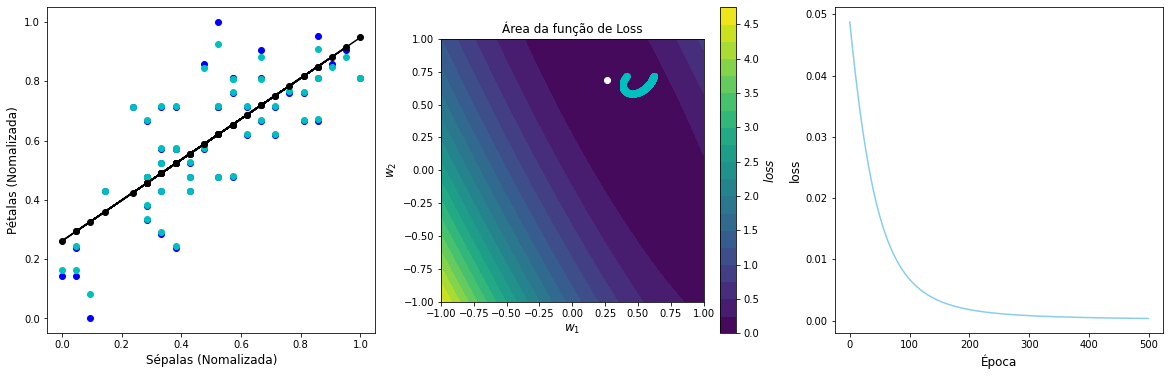

In [ ]:
#Estático
from matplotlib import cm # Colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns  # Fancier plots


fig = plt.figure(figsize=(20, 6))

# 1º Gráfico:
y_opt = w_opt[0,0].item() + x_train_n * w_opt[1,0].item()
y_pred = model.forward(x_train_n)

ax1 = fig.add_subplot(131)
CS1 = plt.scatter(x_train_n.reshape(-1),y_train_n.reshape(-1),color='blue')
ax1.plot(x_train_n, y_pred, 'co', label='Fitting Line')
ax1.plot(x_train_n, y_opt, 'ko-', label='Fitting Line')
ax1.set_xlabel('Sépalas (Nomalizada)', fontsize=12)
ax1.set_ylabel('Pétalas (Nomalizada)', fontsize=12)

# ----------------------------

ax2 = fig.add_subplot(132)
ax2.set_aspect('equal')
CS2 = plt.contourf(wsa, wsb, loss_grid, 20, cmap=cm.viridis)

divider = make_axes_locatable(ax2)
cbar = plt.colorbar()
cbar.ax.set_ylabel('$loss$', fontsize=12)
ax2.plot(w_opt[0,0],w_opt[1,0],'wo')

for i in range(len(w_history)):
  w_lo = w_history[i]
  ax2.plot(w_lo[0],w_lo[1],'co')
ax2.set_xlabel('$w_1$', fontsize=12)
ax2.set_ylabel('$w_2$', fontsize=12)
ax2.set_title('Área da função de Loss')


ax3 = fig.add_subplot(133)
CS3 = sns.lineplot(data=losses,color='skyblue')
ax3.set_xlabel('Época', fontsize=12)
ax3.set_ylabel('loss', fontsize=12)

divider = make_axes_locatable(ax3)


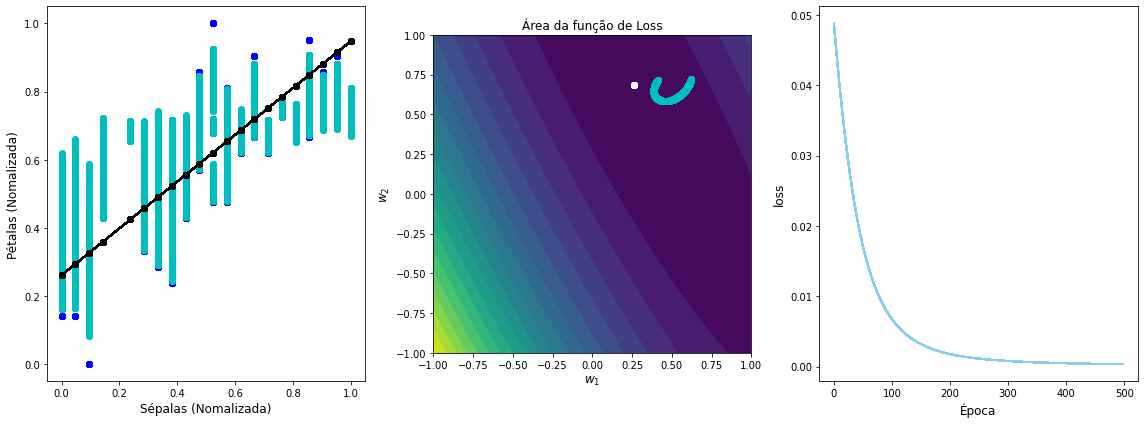

In [ ]:
from celluloid import Camera

fig = plt.figure(figsize=(16, 6))
camera = Camera(fig)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

y_opt = w_opt[0,0].item() + x_train_n * w_opt[1,0].item()

w_animation_part = []
for i in range(num_iterations):

  # 1º Graphic
  # y_pred = model(x_train_bias)

  ax1.scatter(x_train_n.reshape(-1),y_train_n.reshape(-1),color='blue')

  ax1.plot(x_train_n, out_history[i], 'co', label='Fitting Line')

  ax1.plot(x_train_n, y_opt, 'ko-', label='Fitting Line')
  ax1.set_xlabel('Sépalas (Nomalizada)', fontsize=12)
  ax1.set_ylabel('Pétalas (Nomalizada)', fontsize=12)

  # 2º Graphic
  CS2 = ax2.contourf(wsa, wsb, loss_grid, 20, cmap=cm.viridis) #plot da área
  ax2.plot(w_opt[0,0],w_opt[1,0],'wo')  # plot ponto ideal
  ax2.set_aspect('equal')
  w_lo = w_history[i]

  w_animation_part.append(w_lo)
  for j in range(len(w_animation_part)):
    ax2.plot(w_animation_part[j][0],w_animation_part[j][1],'co')
  ax2.set_xlabel('$w_1$', fontsize=12)
  ax2.set_ylabel('$w_2$', fontsize=12)
  ax2.set_title('Área da função de Loss')

  # 3º Graphic
  ax3 = sns.lineplot(data=losses[:i],color='skyblue')
  ax3.set_xlabel('Época', fontsize=12)
  ax3.set_ylabel('loss', fontsize=12)

  plt.tight_layout()
  camera.snap()

In [ ]:
animation = camera.animate()

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())